# ***Classification Performance Metrics***

## ***Titanic***

Bu ödevde, bir önceki derste Titanic verileri ile oluşturduğunuz modelin performansını ölçeceksiniz.

- Modelinizin performansına bu derste öğrendiğiniz metriklerlerle değerlendiriniz.
- ROC eğrisi ve Hassasiyet/Duyarlılık Eğrisini farklı "c" değerleri için çizdirin.
---

In [375]:
import pandas as pd
import numpy as np
# grafiksel araclar
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
sns.set(style="whitegrid")
# logistic regresyon icin
from sklearn.linear_model import LogisticRegression
# lineer regresyon icin
from sklearn.linear_model import LinearRegression
# egitim verisini ayirmak icin
from sklearn.model_selection import train_test_split
# hata matrisi olusturmak icin
from sklearn.metrics import confusion_matrix
# tahmin performansi icin
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
# performans metrikleri icin
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# roc egrisi icin
from sklearn.metrics import roc_curve, roc_auc_score
# hassasiyet duyarlilik egrisi icin
from sklearn.metrics import precision_recall_curve
# logaritmik kayip icin
from sklearn.metrics import log_loss


# uyarilari dikkate alma
import warnings
warnings.filterwarnings('ignore')

# pandas varsayilan olarak cok sayida sutun veya satir varsa tumunu gostermez
# bu nedenle 100 sutun ve satir gostermesi icin
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# virgulden sonra belirli sayida basamak gosterimi icin 
pd.options.display.float_format = '{:,.3f}'.format
# aciklama sutunun tam cikmasi icin
pd.options.display.max_colwidth = 100

# font tanimlamalari
title_font = {'family': 'times new roman', 'color': 'darkred', 
              'weight': 'bold', 'size': 14}
axis_font  = {'family': 'times new roman', 'color': 'darkred', 
              'weight': 'bold', 'size': 14}

# veri setini dataframe icerisine yukle
titanic = pd.read_csv('data/train.csv')

- Fonksiyon tanimlamalari.

In [376]:
# performance degerlerini tutacak df
performance_df = pd.DataFrame( columns=['description', 'accuracy', 'error_rate', 
                                        'precision', 'sensitivity', 'specifity', 'f1score'])

performance_df.index.name = 'model'

# dogruluk degerlerini df kaydeden fonksiyon
def save_performance(model_nu, description, confusion_matrix_test, y_test, y_test_pred):    
    global performance_df
    # hata matrisi degerleri
    tn = confusion_matrix_test[0][0]
    tp = confusion_matrix_test[1][1]
    fp = confusion_matrix_test[0][1]
    fn = confusion_matrix_test[1][0]
    # model varsa drop et
    if (performance_df.index==model_nu).any():
        performance_df.drop(index=model_nu, inplace=True)    
    df = pd.DataFrame([])
    df.index.name = 'model'
    df.loc[model_nu, 'description'] = description
    df.loc[model_nu, 'accuracy'] = (tn + tp)/(fn + fp + tn + tp)
    df.loc[model_nu, 'error_rate'] = 1 - (tn + tp)/(fn + fp + tn + tp)
    df.loc[model_nu, 'precision'] = (tp)/(fp + tp)
    df.loc[model_nu, 'sensitivity'] = (tp)/(tp + fn)
    df.loc[model_nu, 'specifity'] = (tn)/(tn + fp)
    df.loc[model_nu, 'f1score'] = f1_score(y_test, y_test_pred)
    performance_df = pd.concat([performance_df, df]) 

In [377]:
display(performance_df)

,description,accuracy,error_rate,precision,sensitivity,specifity,f1score
model,,,,,,,


### Veri Kesfi
- Veri setini inceleme.

In [378]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [379]:
for val in titanic['Pclass'].unique():
    print(val, '{:.3f}'.format(titanic.loc[titanic['Pclass']==val, 'Cabin'].isnull().mean()))

3 0.976
1 0.185
2 0.913


- Pclass 2 ve 3 olanlarin Cabin numaralari genelde bos (sirasiyla %91 ve %97), 1 inci sinif yolcularda ise %18 in Cabin numarasi bos.
- Nan degerleri 'None' string degeriyle doldurabiliriz.

In [380]:
titanic['Cabin'].fillna('None', inplace=True)

In [381]:
titanic['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [382]:
for val in titanic['Embarked'].unique()[0:3]:    
    print(val, titanic.loc[titanic['Embarked']==val, 'PassengerId'].count())

S 644
C 168
Q 77


- Embarked 3 farkli deger almis, eksik veriler en sik karsilasilan degerle doldurulabilir.

In [383]:
titanic['Embarked'].fillna('S', inplace=True)

- Son olarak yas degeri de ortalama deger ile dolduruldu.

In [384]:
np.floor(titanic['Age'].mean())

29.0

In [385]:
titanic['Age'].fillna(np.floor(titanic['Age'].mean()), inplace=True)

In [386]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### ***1. Model: Sadece numerik degiskenler***

- Hedef (bagimli) degisken : Survived
- Aciklayici (bagimsiz) degiskenler : Diger tum degiskenler

In [387]:
# aciklayici degiskenler numerik olanlar  
expl_vars = [column for column in titanic.columns 
                if titanic.dtypes[column] != 'object']
# aciklayici degiskenlerden hedef degisken ve id degiskeni ayrilir
expl_vars.remove('Survived')
expl_vars.remove('PassengerId')
expl_vars

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [388]:
# hedef ve aciklayici degiskenler
Y = titanic['Survived']
X = titanic[expl_vars]

# egitim ve test veri kumelerine ayirma
X_train, X_test, Y_train, Y_test =  train_test_split(X, Y, test_size=0.20, random_state=111)

# log reg model nesnesi olustur
log_reg = LogisticRegression()

# modeli egit
log_reg.fit(X_train, Y_train)

# tahmin yap
Y_train_pred = log_reg.predict(X_train)
Y_test_pred = log_reg.predict(X_test)

# hata matrisi olustur
confusion_matrix_train = confusion_matrix(Y_train, Y_train_pred)
confusion_matrix_test = confusion_matrix(Y_test, Y_test_pred)


# performans degerlerini kaydet
save_performance(1, 'numerik degiskenler', confusion_matrix_test, Y_test, Y_test_pred)
performance_df

,description,accuracy,error_rate,precision,sensitivity,specifity,f1score
model,,,,,,,
1,numerik degiskenler,0.698,0.302,0.625,0.455,0.841,0.526


### ***1. Model ROC Egrisi***
- C degerleri degistirilerek ROC egrisi cizdirilir. C degeri varsayilan olarak 1.

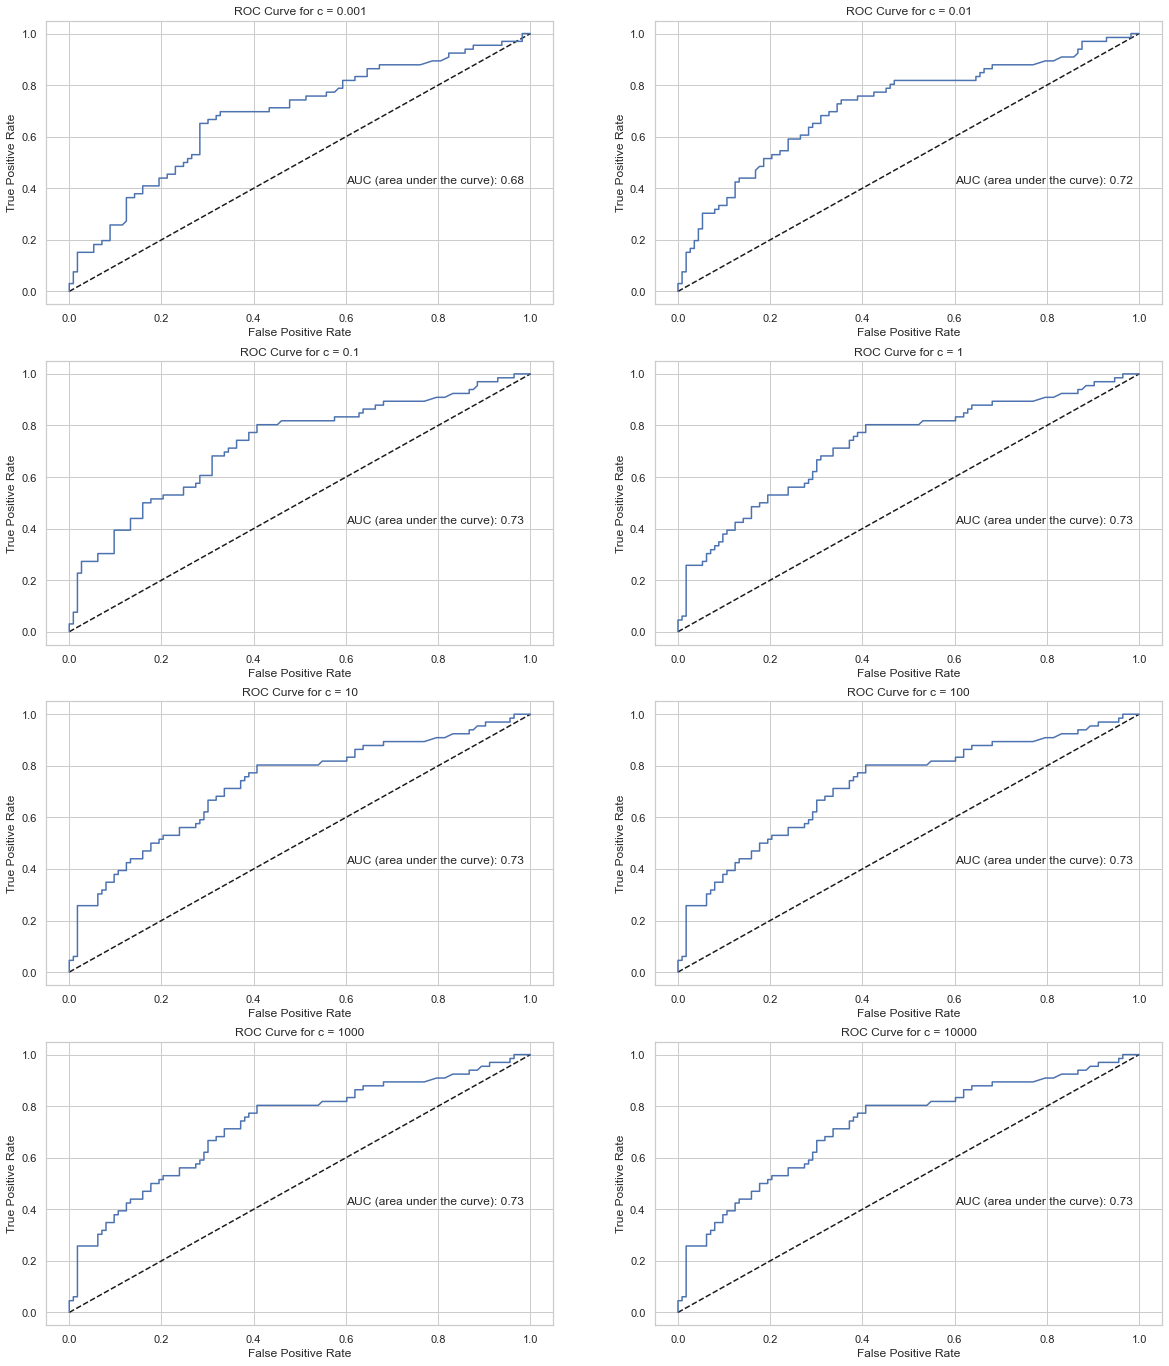

In [351]:
# c degerleri
c_vals = [0.001`,0.01,0.1,1,10,100, 1000, 10000]

plt.figure(figsize=(20,24))
for i, c in enumerate(c_vals):
    
    # egitim verisi ile logistic regresyon modeli olustur
    lr = LogisticRegression(penalty = 'l2', C = c, random_state = 111)
    lr.fit(X_train,Y_train)
    # test tahminlerinin ihtimallerinden 1 olma ihtimal degerlerini aldik 
    # 0 inci sutun 0 olma ihtimal degerlerini tutuyor
    test_pred_proba = lr.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds  = roc_curve(Y_test, test_pred_proba)
    # ROC grafigi
    plt.subplot(4,2,i+1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for c = {}'.format(c))
    plt.annotate('AUC (area under the curve): {:.2f}'.format(roc_auc_score(Y_test, test_pred_proba)) , xy=(0.6,0.42))

plt.show()

#### ***1. Model Hassasiyet Duyarlilik Egrisi ve Logaritmik Kayip***

- Hassasiyet Duyarlılık eğrisi sınıf sayılarında bir dengesizlik olduğu zaman kullanılan bir metriktir. 
- Titanic verisinde %38 Survived orani var ve siniflar arasi cok dengesizlik yok.

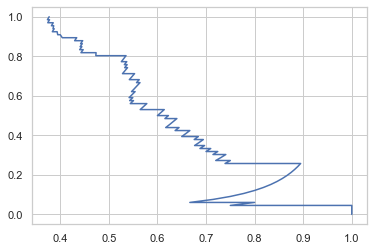

In [352]:
# egitim verisi ile logistic regresyon modeli olustur
# en iyi performasli ROC egrisindeki  c degeri 
log_reg = LogisticRegression(penalty = 'l2', C = 1, random_state = 111)
log_reg.fit(X_train,Y_train)
# test tahminlerinin ihtimalleri
test_pred_proba = log_reg.predict_proba(X_test)[:,1]

sensitivity, precision, _ = precision_recall_curve(Y_test, test_pred_proba)

plt.plot(sensitivity, precision)
plt.show()

- Düşük log-loss değerleri daha iyi tahmin demektir. Hata oranı değerine benzemektedir. 

In [353]:
# once tahmin yapalim
Y_test_pred = log_reg.predict(X_test)

# logaritmik kayip ve hata orani
print("Logartimik Kayıp (log-loss) : " , log_loss(Y_test, test_pred_proba))
print("Hata Oranı                  : " , 1- accuracy_score(Y_test, Y_test_pred))

Logartimik Kayıp (log-loss) :  0.5783147719654448
Hata Oranı                  :  0.3016759776536313


### ***2. Model: Cinsiyet ve Liman bilgisi dahil***
- Kadin kurtulam orani fazla oldugundan kadin 1, erkek 0.
- Liman bilgisi de kurtulma oranina gore siralanarak encode edildi.

In [354]:
titanic[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.742
male,0.189


In [355]:
titanic['Sex'].replace({'female': 1, 'male': 0}, inplace=True)

In [356]:
titanic[['Embarked', 'Survived']].groupby('Embarked').mean()

,Survived
Embarked,
C,0.554
Q,0.390
S,0.339


In [357]:
titanic['Embarked'].replace({'C': 3, 'Q': 2, 'S': 1}, inplace=True)

In [358]:
# aciklayici degiskenler numerik olanlar  
expl_vars = [column for column in titanic.columns 
                if titanic.dtypes[column] != 'object']
# aciklayici degiskenlerden hedef degisken ve id degiskeni ayrilir
expl_vars.remove('Survived')
expl_vars.remove('PassengerId')
expl_vars

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

In [359]:
# hedef ve aciklayici degiskenler
Y = titanic['Survived']
X = titanic[expl_vars]

# egitim ve test veri kumelerine ayirma
X_train, X_test, Y_train, Y_test =  train_test_split(X, Y, test_size=0.20, random_state=111)

# log reg model nesnesi olustur
log_reg = LogisticRegression()

# modeli egit
log_reg.fit(X_train, Y_train)

# tahmin yap
Y_train_pred = log_reg.predict(X_train)
Y_test_pred = log_reg.predict(X_test)

# hata matrisi olustur
confusion_matrix_train = confusion_matrix(Y_train, Y_train_pred)
confusion_matrix_test = confusion_matrix(Y_test, Y_test_pred)

# performans degerlerini kaydet
save_performance(2, 'cinsiyet ve liman bilgisi dahil', confusion_matrix_test, Y_test, Y_test_pred)
performance_df


,description,accuracy,error_rate,precision,sensitivity,specifity,f1score
model,,,,,,,
1,numerik degiskenler,0.698,0.302,0.625,0.455,0.841,0.526
2,cinsiyet ve liman bilgisi dahil,0.771,0.229,0.687,0.697,0.814,0.692


### ***2. Model ROC Egrisi***
- C degerleri degistirilerek ROC egrisi cizdirilir. C degeri varsayilan olarak 1.

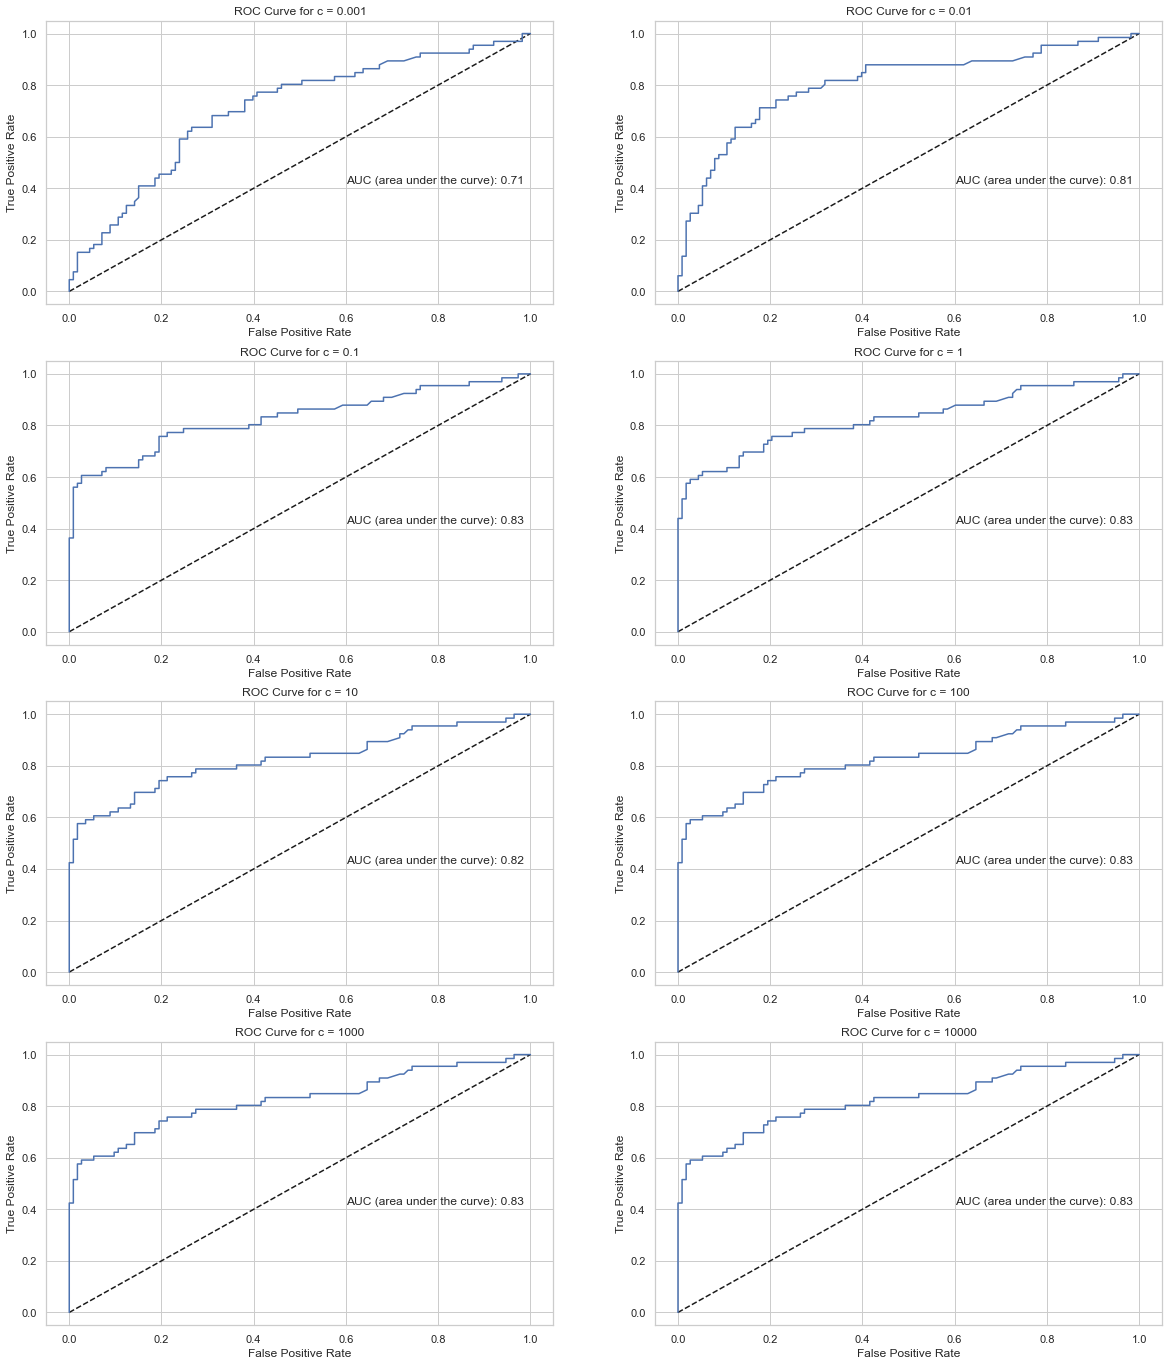

In [360]:
# c degerleri
c_vals = [0.001,0.01,0.1,1,10,100, 1000, 10000]

plt.figure(figsize=(20,24))
for i, c in enumerate(c_vals):
    
    # egitim verisi ile logistic regresyon modeli olustur
    lr = LogisticRegression(penalty = 'l2', C = c, random_state = 111)
    lr.fit(X_train,Y_train)
    # test tahminlerinin ihtimallerinden 1 olma ihtimal degerlerini aldik 
    # 0 inci sutun 0 olma ihtimal degerlerini tutuyor
    test_pred_proba = lr.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds  = roc_curve(Y_test, test_pred_proba)
    # ROC grafigi
    plt.subplot(4,2,i+1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for c = {}'.format(c))
    plt.annotate('AUC (area under the curve): {:.2f}'.format(roc_auc_score(Y_test, test_pred_proba)) , xy=(0.6,0.42))

    

plt.show()

### ***3. Model: Yasi tahminle doldurarak***
- Yas degiskenindeki eksik degerler lineer regresyon yontemiyle doldurulacaktir.

In [361]:
titanic = pd.read_csv('data/train.csv')

titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- Eksik degerler Yas haric onceki gibi doldurulur.

In [362]:
titanic['Cabin'].fillna('None', inplace=True)

titanic['Embarked'].fillna('S', inplace=True)

- Cinsiyet ve liman bilgisi onceki gibi encode edilir.

In [363]:
titanic['Sex'].replace({'female': 1, 'male': 0}, inplace=True)
titanic['Embarked'].replace({'C': 3, 'Q': 2, 'S': 1}, inplace=True)

In [364]:
titanic['Age'].isnull().mean()

0.19865319865319866

- Yas bilgisinin null orani da 80 e 20 kuaralina uymaktadir.

- Yas degeri olan ve olmayan data ikiye ayrildi

In [365]:
titanic_no_age = titanic[titanic['Age'].isnull()]

In [366]:
titanic_w_age = titanic[titanic['Age'].notnull()]

- Hedef (bagimli) degisken : Yas
- Aciklayici (bagimsiz) degiskenler : Diger tum numerik degiskenler

In [367]:
# aciklayici degiskenler numerik olanlar  
expl_vars = [column for column in titanic_w_age.columns 
                if titanic_w_age.dtypes[column] != 'object']
# aciklayici degiskenlerden hedef degisken ve id degiskeni ayrilir
expl_vars.remove('Age')
expl_vars.remove('PassengerId')
expl_vars

['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked']

In [368]:
# hedef ve aciklayici degiskenler
Y = titanic_w_age['Age']
X = titanic_w_age[expl_vars]

# egitim ve test veri kumelerine ayirma
X_train, X_test, Y_train, Y_test =  train_test_split(X, Y, test_size=0.20, random_state=111)

# log reg model nesnesi olustur
lrm = LinearRegression()
# modeli egit
lrm.fit(X_train, Y_train)

# rsquare skorlari
train_rsquare = lrm.score(X_train, Y_train)
test_rsquare = lrm.score(X_test, Y_test)

# test verisi ile tahmin
Y_test_pred = lrm.predict(X_test)
# egitim verisi ile tahmin
Y_train_pred = lrm.predict(X_train)

print('Egitim rsquare degeri: ', train_rsquare, 
      'Test rsquare degeri:', test_rsquare, 
      'RMSE degeri: ', rmse(Y_test, Y_test_pred) , sep='\n')


Egitim rsquare degeri: 
0.27711273581074836
Test rsquare degeri:
0.2501980404839499
RMSE degeri: 
13.036706369815096


- Bir kez daha model olusturuyoruz. Bu defa daha cok veriyle doldurmak icin split etmeden olusturduk. Yas degeri olmayan verilerle de tahmin yaparak yas degerini dolduracagiz.

In [369]:
Y = titanic_w_age['Age']
X = titanic_w_age[expl_vars]

# model nesnesi olustur
lrm = LinearRegression()
# modeli egit
lrm.fit(X, Y)

# tahmini yas degeri olmayan data uzerinde yaptik
# yas degeri eksi ya da ondalikli olmasin 
titanic_no_age['Age'] = np.floor(np.abs(lrm.predict(titanic_no_age[expl_vars])))

In [370]:
# iki veri kumesini birlestir
titanic = pd.concat([titanic_no_age, titanic_w_age])
# sirala
titanic = titanic.sort_values(by='PassengerId')

In [371]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    int64  
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     891 non-null    int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 90.5+ KB


- Nihai logistic regression modelini olusturalim.

In [372]:
# aciklayici degiskenler numerik olanlar  
expl_vars = [column for column in titanic.columns 
                if titanic.dtypes[column] != 'object']
# aciklayici degiskenlerden hedef degisken ve id degiskeni ayrilir
expl_vars.remove('Survived')
expl_vars.remove('PassengerId')
expl_vars

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

In [373]:
# hedef ve aciklayici degiskenler
Y = titanic['Survived']
X = titanic[expl_vars]

# egitim ve test veri kumelerine ayirma
X_train, X_test, Y_train, Y_test =  train_test_split(X, Y, test_size=0.20, random_state=111)

# log reg model nesnesi olustur
log_reg = LogisticRegression()

# modeli egit
log_reg.fit(X_train, Y_train)

# tahmin yap
Y_train_pred = log_reg.predict(X_train)
Y_test_pred = log_reg.predict(X_test)

# hata matrisi olustur
confusion_matrix_train = confusion_matrix(Y_train, Y_train_pred)
confusion_matrix_test = confusion_matrix(Y_test, Y_test_pred)

# performans degerlerini kaydet
save_performance(3, 'yas tahminle dolduruldu',  confusion_matrix_test, Y_test, Y_test_pred)
performance_df


,description,accuracy,error_rate,precision,sensitivity,specifity,f1score
model,,,,,,,
1,numerik degiskenler,0.698,0.302,0.625,0.455,0.841,0.526
2,cinsiyet ve liman bilgisi dahil,0.771,0.229,0.687,0.697,0.814,0.692
3,yas tahminle dolduruldu,0.799,0.201,0.734,0.712,0.850,0.723


### ***3. Model ROC Egrisi***
- C degerleri degistirilerek ROC egrisi cizdirilir. C degeri varsayilan olarak 1.

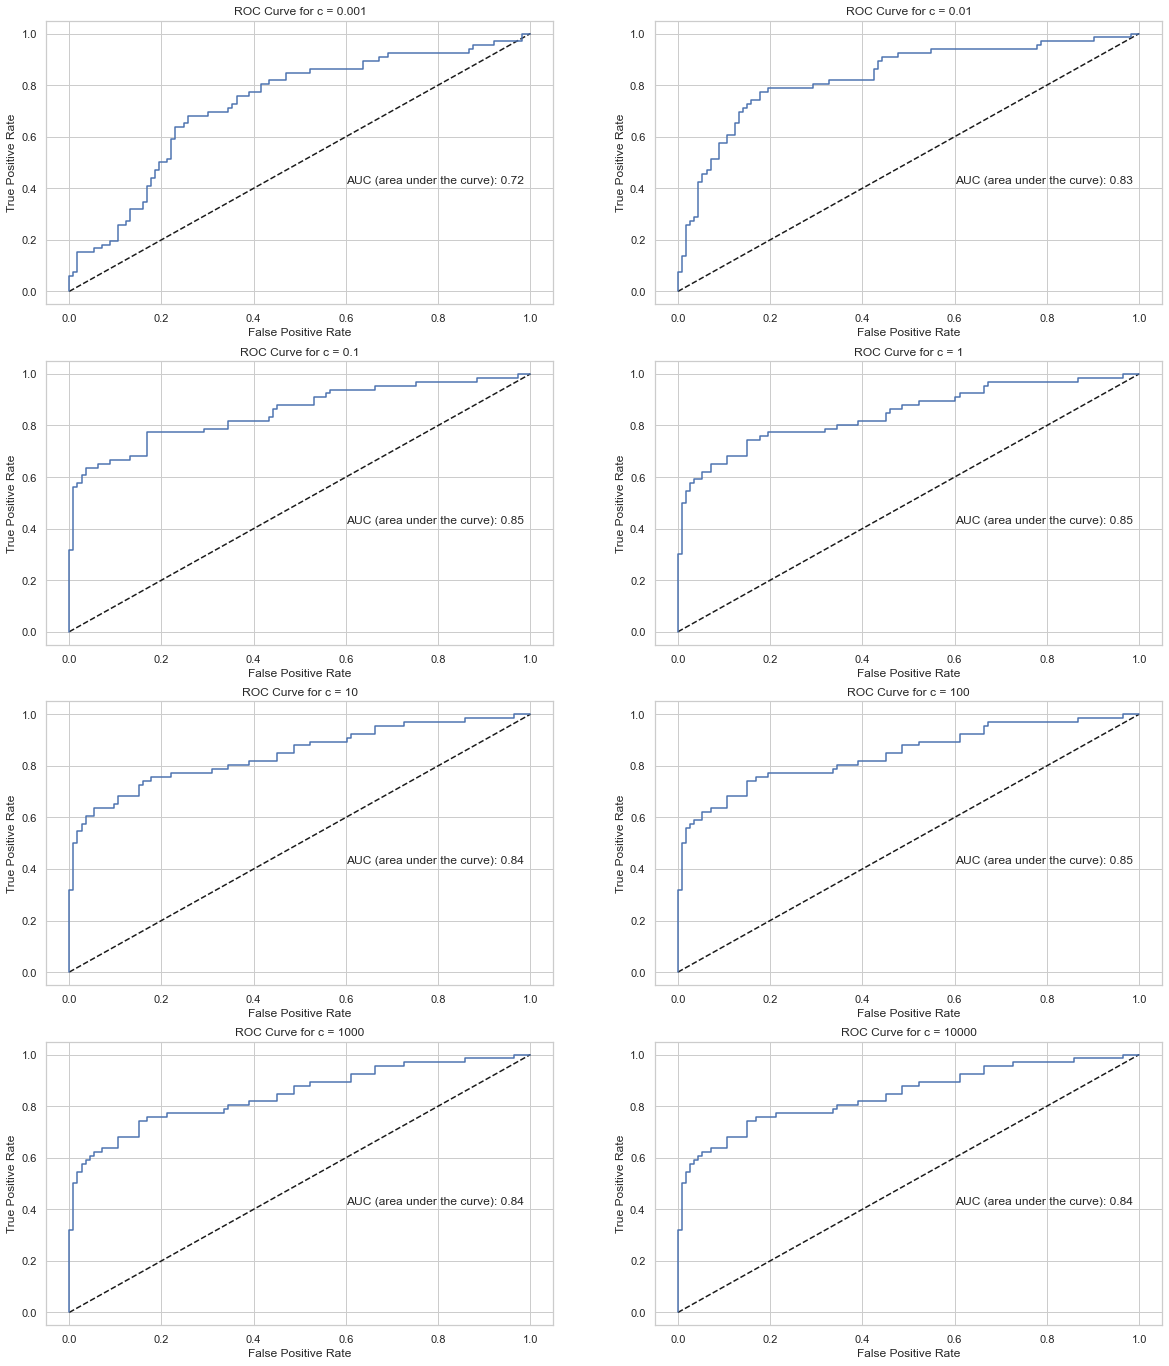

In [374]:
# c degerleri
c_vals = [0.001,0.01,0.1,1,10,100, 1000, 10000]

plt.figure(figsize=(20,24))
for i, c in enumerate(c_vals):
    
    # egitim verisi ile logistic regresyon modeli olustur
    lr = LogisticRegression(penalty = 'l2', C = c, random_state = 111)
    lr.fit(X_train,Y_train)
    # test tahminlerinin ihtimallerinden 1 olma ihtimal degerlerini aldik 
    # 0 inci sutun 0 olma ihtimal degerlerini tutuyor
    test_pred_proba = lr.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds  = roc_curve(Y_test, test_pred_proba)
    # ROC grafigi
    plt.subplot(4,2,i+1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for c = {}'.format(c))
    plt.annotate('AUC (area under the curve): {:.2f}'.format(roc_auc_score(Y_test, test_pred_proba)) , xy=(0.6,0.42))
    

plt.show()